# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import common libraries for data transformation with pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import datetime
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
import seaborn as sns

# import pyspark.ml package for building machine learning model
from pyspark.ml import pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
spark_df = spark.read.json(path)

In [4]:
spark_df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
spark_df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
len(spark_df.columns)

18

In [7]:
spark_df.count()

286500

In [8]:
spark_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
spark_df.where(col('userId').isNull()).count()

0

In [10]:
# count the number of users in dataset
spark_df.select('userId').dropDuplicates().count()

226

In [11]:
# display unique values of column page
spark_df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



## Data Preprocessing
This includes:
+ Data Cleaning: rename columns, convert data types, remove null values, drop duplicates
+ Data Transformation: derive new columns

In [12]:
# data cleaning
clean_df = spark_df

In [13]:
# convert columns ts & registration to timestamp
ms_to_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))

clean_df = clean_df.withColumn("datetime_ts", ms_to_timestamp('ts'))
clean_df = clean_df.withColumn("datetime_ts_registration", ms_to_timestamp('registration'))

In [14]:
# spark_df.describe().show()

In [15]:
clean_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime_ts: string (nullable = true)
 |-- datetime_ts_registration: string (nullable = true)



In [16]:
df = clean_df

In [17]:
# derive new columns: is_downgrade, is_churn
# derive a downgrade label
udf_downgrade_value = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgrade_value", udf_downgrade_value("page"))

# find all users who downgraded
dg_window = Window.partitionBy('userId')
df = df.withColumn("is_downgrade", max('downgrade_value').over(dg_window))

# derive a churn label
udf_churn_value = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churn_value", udf_churn_value("page"))

# find all users who churned
churn_window = Window.partitionBy('userId')
df = df.withColumn("is_churn", max('churn_value').over(churn_window))

# # selecting few users to see
df.select(['userId', 'firstName', 'level','datetime_ts','is_churn', 'is_downgrade']).dropDuplicates(subset = ['userId']).show(10)

+------+---------+-----+-------------------+--------+------------+
|userId|firstName|level|        datetime_ts|is_churn|is_downgrade|
+------+---------+-----+-------------------+--------+------------+
|100010| Darianna| free|10-08-2018 12:58:54|       0|           0|
|200002|  Dominic| free|10-01-2018 11:30:30|       0|           0|
|   125|    Mason| free|10-12-2018 04:05:44|       1|           0|
|   124|   Nicole| paid|10-01-2018 15:17:10|       0|           0|
|    51|    Ethan| paid|10-01-2018 12:57:12|       1|           0|
|     7|   Maddox| free|10-03-2018 11:57:49|       0|           0|
|    15|    Panav| paid|10-01-2018 10:23:35|       0|           0|
|    54|    Alexi| paid|10-01-2018 00:32:10|       1|           1|
|   155|   Camila| free|11-02-2018 15:56:25|       0|           0|
|100014|  Rodrigo| paid|10-10-2018 13:12:16|       1|           0|
+------+---------+-----+-------------------+--------+------------+
only showing top 10 rows



In [18]:
# gender distribution between churn users and regular users
df.drop_duplicates(['userId', 'gender']).groupby(['is_churn', 'gender']).count().sort("is_churn").show()

+--------+------+-----+
|is_churn|gender|count|
+--------+------+-----+
|       0|     M|   89|
|       0|     F|   84|
|       0|  null|    1|
|       1|     F|   20|
|       1|     M|   32|
+--------+------+-----+



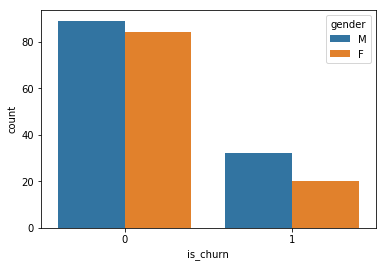

In [19]:
# plotting a bar plot to show gender distribution between regular and churn users
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['is_churn', 'gender']).count().sort("is_churn").toPandas()
sns.barplot(x = 'is_churn', y = 'count', data = df_ch_pd, hue = 'gender')

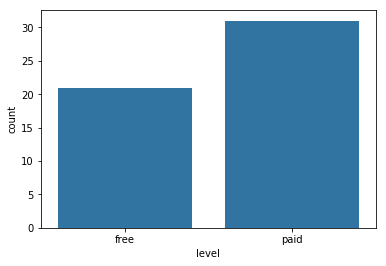

In [20]:
# finding out which level customers churn more
level_df = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[0])

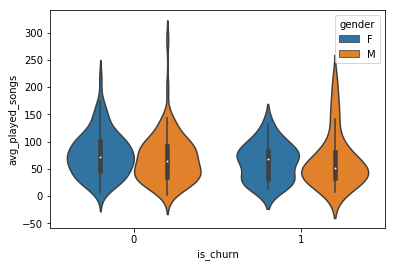

In [21]:
# gender distribution for number of songs played per session for churned and regular users
df_total_songs = df.where('page == "NextSong"').groupby(['is_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['is_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

ax = sns.violinplot('is_churn', y = 'avg_played_songs', hue = 'gender', data = df_total_songs)

From the chart, we can see that churned users played less number of songs per sessions compared to normal users.

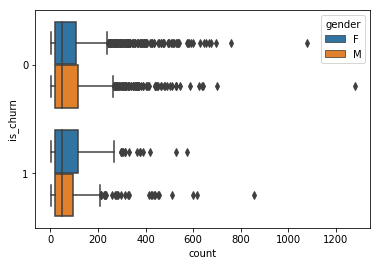

In [22]:
# graph distribution of users churned by gender
df_ops = df.groupby("is_churn", "userId", "sessionId", 'gender').count().toPandas()
sns.boxplot(x = 'count', y = 'is_churn', orient = 'horizontal', data = df_ops, hue = 'gender')

From the chart, we can see that churn users performed less compared to normal users. And, female users are more likely to churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [23]:
# feature 1: calculate the total number of songs played
feature_1 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
feature_1.show()

+------+-----------+
|userId|total_songs|
+------+-----------+
|100010|        381|
|200002|        474|
|   125|         11|
|    51|       2464|
|   124|       4825|
|     7|        201|
|    54|       3437|
|    15|       2278|
|   155|       1002|
|   132|       2304|
|   154|        118|
|100014|        310|
|   101|       2149|
|    11|        848|
|   138|       2469|
|300017|       4428|
|    29|       3603|
|    69|       1342|
|100021|        319|
|    42|       4257|
+------+-----------+
only showing top 20 rows



In [24]:
# feature 2: calculate the number of thumbs up
feature_2 = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_up')
feature_2.show()

+------+---------------+
|userId|total_thumbs_up|
+------+---------------+
|100010|             17|
|200002|             21|
|    51|            100|
|   124|            171|
|     7|              7|
|    54|            163|
|    15|             81|
|   155|             58|
|   132|             96|
|   154|             11|
|100014|             17|
|   101|             86|
|    11|             40|
|   138|             95|
|300017|            303|
|    29|            154|
|    69|             72|
|100021|             11|
|    42|            166|
|   112|              9|
+------+---------------+
only showing top 20 rows



In [25]:
# feature 3: calculate the number of thumbs down
feature_3 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'total_thumbs_down')
feature_3.show()

+------+-----------------+
|userId|total_thumbs_down|
+------+-----------------+
|100010|                5|
|200002|                6|
|    51|               21|
|   124|               41|
|     7|                1|
|    15|               14|
|    54|               29|
|   155|                3|
|   132|               17|
|100014|                3|
|   101|               16|
|    11|                9|
|   138|               24|
|300017|               28|
|    29|               22|
|    69|                9|
|100021|                5|
|    42|               25|
|   112|                3|
|    73|                7|
+------+-----------------+
only showing top 20 rows



In [26]:
# feature 4: calculate the life time since registration
feature_4 = df.select('userId', 'registration', 'ts').withColumn('total_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'total_lifetime' : 'max'})\
    .withColumnRenamed('max(total_lifetime)', 'total_lifetime')\
    .select('userId', (col('total_lifetime')/1000/3600/24).alias('total_lifetime'))
feature_4.show()

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
|     7| 72.77818287037037|
|    54|110.75168981481481|
|    15|56.513576388888886|
|   155|23.556018518518517|
|   132|  66.8891087962963|
|   154|23.872037037037035|
|100014| 85.08340277777778|
|   101|53.965937499999995|
|    11|124.47825231481481|
|   138| 66.62668981481481|
|300017| 74.35851851851852|
|    29|60.104050925925925|
|    69| 71.42444444444445|
|100021| 64.73886574074074|
|    42| 67.11364583333334|
+------+------------------+
only showing top 20 rows



In [27]:
# feature 5: calcukate the total length of listening utilizing all services
feature_5 = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'total_listen_time')
feature_5.show()

+------+------------------+
|userId| total_listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [28]:
# feature 6: calcualte the total number of friends
feature_6 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')
feature_6.show()

+------+-------------+
|userId|total_friends|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



In [29]:
# feature 7: gender of the user
# female: 0, male: 1
feature_7 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

feature_7.show()

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    40|     0|
|    94|     0|
|    35|     0|
|    75|     0|
|   116|     0|
|200001|     1|
|200020|     1|
|100008|     0|
|200015|     1|
|   100|     1|
|100006|     0|
|300005|     0|
|    25|     0|
+------+------+
only showing top 20 rows



In [30]:
# feature 8: calculate the total number of songs listened per session
feature_8 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

feature_8.show()

+------+------------------+
|userId|  avg_played_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [31]:
# feature 9: calculate the total number of artists the user has listened to
feature_9 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "total_artist_listened")
feature_9.show()

+------+---------------------+
|userId|total_artist_listened|
+------+---------------------+
|100010|                  252|
|200002|                  339|
|   125|                    8|
|    51|                 1385|
|   124|                 2232|
|     7|                  142|
|    15|                 1302|
|    54|                 1744|
|   155|                  643|
|   132|                 1299|
|   154|                   78|
|100014|                  233|
|   101|                 1241|
|    11|                  534|
|   138|                 1332|
|300017|                 2070|
|    29|                 1804|
|    69|                  865|
|100021|                  207|
|    42|                 2073|
+------+---------------------+
only showing top 20 rows



In [32]:
# setting the churn label for our model
df_label = df.select('userId', 'is_churn').dropDuplicates()
df_label.show()

+------+--------+
|userId|is_churn|
+------+--------+
|100010|       0|
|200002|       0|
|   125|       1|
|   124|       0|
|    51|       1|
|     7|       0|
|    15|       0|
|    54|       1|
|   155|       0|
|100014|       1|
|   132|       0|
|   154|       0|
|   101|       1|
|    11|       0|
|   138|       0|
|300017|       0|
|100021|       1|
|    29|       1|
|    69|       0|
|   112|       0|
+------+--------+
only showing top 20 rows



In [33]:
# combine all features with the churn label
df_features = feature_1.join(feature_2, 'userId', 'inner').join(feature_3, 'userId', 'inner').join(feature_4, 'userId', 'inner')\
             .join(feature_5, 'userId', 'inner').join(feature_6, 'userId', 'inner').join(feature_7, 'userId', 'inner')\
             .join(feature_8, 'userId', 'inner').join(feature_9, 'userId', 'inner').join(df_label, 'userId', 'inner').drop('userId')

df_features.show()

+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+---------------------+--------+
|total_songs|total_thumbs_up|total_thumbs_down|    total_lifetime| total_listen_time|total_friends|gender|  avg_played_songs|total_artist_listened|is_churn|
+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+---------------------+--------+
|        381|             17|                5|  55.6436574074074| 66940.89735000003|            4|     0|39.285714285714285|                  252|       0|
|        474|             21|                6| 70.07462962962963| 94008.87593999993|            4|     1|              64.5|                  339|       0|
|       2464|            100|               21|19.455844907407407| 523275.8428000004|           28|     1|             211.1|                 1385|       1|
|       4825|            171|               41|131.5559143

In [34]:
df_features.printSchema()

root
 |-- total_songs: long (nullable = false)
 |-- total_thumbs_up: long (nullable = false)
 |-- total_thumbs_down: long (nullable = false)
 |-- total_lifetime: double (nullable = true)
 |-- total_listen_time: double (nullable = true)
 |-- total_friends: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- avg_played_songs: double (nullable = true)
 |-- total_artist_listened: long (nullable = false)
 |-- is_churn: integer (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
# step 1: vectorize all the features

input_cols = ['total_songs', 'total_thumbs_up', 'total_thumbs_down', 'total_lifetime', 'total_listen_time', 'total_friends', 'gender', 'avg_played_songs', 'total_artist_listened']
assmblr = VectorAssembler(inputCols = input_cols, outputCol = "VectFeatures")
final_df = assmblr.transform(df_features)
final_df.show()

+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+---------------------+--------+--------------------+
|total_songs|total_thumbs_up|total_thumbs_down|    total_lifetime| total_listen_time|total_friends|gender|  avg_played_songs|total_artist_listened|is_churn|        VectFeatures|
+-----------+---------------+-----------------+------------------+------------------+-------------+------+------------------+---------------------+--------+--------------------+
|        381|             17|                5|  55.6436574074074| 66940.89735000003|            4|     0|39.285714285714285|                  252|       0|[381.0,17.0,5.0,5...|
|        474|             21|                6| 70.07462962962963| 94008.87593999993|            4|     1|              64.5|                  339|       0|[474.0,21.0,6.0,7...|
|       2464|            100|               21|19.455844907407407| 523275.8428000004|           28|     1|    

In [36]:
final_df.printSchema()

root
 |-- total_songs: long (nullable = false)
 |-- total_thumbs_up: long (nullable = false)
 |-- total_thumbs_down: long (nullable = false)
 |-- total_lifetime: double (nullable = true)
 |-- total_listen_time: double (nullable = true)
 |-- total_friends: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- avg_played_songs: double (nullable = true)
 |-- total_artist_listened: long (nullable = false)
 |-- is_churn: integer (nullable = true)
 |-- VectFeatures: vector (nullable = true)



In [37]:
# step 2: standardize all input features
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_df)
final_df = scaler_model.transform(final_df)

In [38]:
final_df.printSchema()

root
 |-- total_songs: long (nullable = false)
 |-- total_thumbs_up: long (nullable = false)
 |-- total_thumbs_down: long (nullable = false)
 |-- total_lifetime: double (nullable = true)
 |-- total_listen_time: double (nullable = true)
 |-- total_friends: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- avg_played_songs: double (nullable = true)
 |-- total_artist_listened: long (nullable = false)
 |-- is_churn: integer (nullable = true)
 |-- VectFeatures: vector (nullable = true)
 |-- newFeatures: vector (nullable = true)



In [39]:
data = final_df.select(final_df.is_churn.alias("label"), final_df.newFeatures.alias("features"))

In [40]:
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.28303716272111...|
|    0|[0.35212497409397...|
|    1|[1.83045556153494...|
|    0|[3.58439451477521...|
|    0|[0.14931881812845...|
|    1|[2.55327750202744...|
|    0|[1.69227993878920...|
|    0|[0.74436545156575...|
|    0|[1.71159481078592...|
|    1|[0.23029270457623...|
|    1|[1.59644845849780...|
|    0|[0.62996197896981...|
|    0|[1.83416995999585...|
|    0|[3.2894712769792,...|
|    1|[2.67659553092955...|
|    0|[0.99694454690742...|
|    1|[0.23697862180586...|
|    0|[3.16243884961618...|
|    0|[0.21692087011696...|
|    1|[0.74510833125793...|
+-----+--------------------+
only showing top 20 rows



In [41]:
# define training set and valuation set
train, val = data.randomSplit([0.90, 0.10], seed = 42)
train = train.cache()

In [42]:
# try the first classifier: Random Forest 
rf_clf = RandomForestClassifier()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [43]:
# evaluate on training set
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.7508242500405957]

In [44]:
# evaluate on valuation set
res_rf = cv_model_rf.transform(val)

In [62]:
# evaluation metrics for Random Forest
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for Random Forest Classifier are as follows :")
print("The F-1 Score is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(res_rf, {evaluator.metricName : "accuracy"})))

The metrics for Random Forest Classifier are as follows :
The F-1 Score is 0.7809523809523808
The accuracy is 0.8


In [46]:
# try the second classifier 2: Support Vector Machine
svm_clf = LinearSVC(maxIter = 15)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_svm = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [47]:
cv_model_svm = cross_val_svm.fit(train)
cv_model_svm.avgMetrics

[0.7015856802373657]

In [48]:
res_svm = cv_model_svm.transform(val)

In [63]:
# evaluation metrics for SVM
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for Support Vector Machine classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_svm, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(res_svm, {evaluator.metricName : "accuracy"})))

The metrics for Support Vector Machine classifier are as follows: 
The F-1 Score is 0.44999999999999996
The accuracy is 0.6


In [50]:
# try the third classifier: Gradient Boosted Trees
gbt_clf = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [51]:
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

[0.6864907971464512]

In [52]:
res_gbt = cv_model_gbt.transform(val)

In [64]:
# evaluation metrics for Gradient Boosted Trees
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The metrics for our Gradient Boosted Trees Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(res_gbt, {evaluator.metricName : "accuracy"})))

The metrics for our Gradient Boosted Trees Classifier are as follows: 
The F-1 Score is 0.7809523809523808
The accuracy is 0.8


### Selecting the classifier
Comparing the F-1 score and accuracy of the three classifiers, we see that Gradient Boosted Trees - GBT has the highest score.
I will select this classifier for the next step: Tuning model

### Tuning Hyperparameters

In [54]:
# Tuning Hyperparameters for the Gradient Boosting Trees model using Grid Search
gbt_clf = GBTClassifier(maxIter = 15, seed = 42)

param_grid_gbt = ParamGridBuilder().addGrid(gbt_clf.maxIter, [10, 15, 20])\
                 .addGrid(gbt_clf.maxDepth, [5, 10]).build()

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

cross_val_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid_gbt, evaluator = f1_evaluation, numFolds = 2)

In [55]:
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

[0.6982776939311534,
 0.6864907971464512,
 0.7022407733199691,
 0.6864907971464512,
 0.7061527660872282,
 0.6864907971464512]

In [60]:
# choosing the parameters with best metrics
gbt_final = GBTClassifier(maxIter = 15 , seed = 42, maxDepth = 5)
gbt_final_model = gbt_final.fit(train)
res_final = gbt_final_model.transform(val)

In [61]:
# Gettting the final evaluation metrics for Gradient Boosted Trees
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The final metrics for our Gradient Boosted Trees Classifier are as follows: ")
print("The F-1 Score is {}".format(evaluator.evaluate(res_final, {evaluator.metricName : "f1"})))
print("The accuracy is {}".format(evaluator.evaluate(res_final, {evaluator.metricName : "accuracy"})))

The final metrics for our Gradient Boosted Trees Classifier are as follows: 
The F-1 Score is 0.7809523809523808
The accuracy is 0.8


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

# References
1. [Apache Spark](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)
2. Data Scientists Guide to Apache Spark, databricks
